📉 Telco Customer Churn Prediction & Revenue Risk Forecasting
📌 Project Overview
Customer churn is one of the largest drivers of revenue loss in subscription-based businesses.
This project builds a machine learning churn prediction system and extends it into a revenue loss forecasting framework, enabling data-driven retention strategy.
Beyond simple classification, this project answers:
Who is likely to churn?
When are they likely to churn?
How much revenue is at risk?
Why is the model predicting churn?
Which customers should we prioritize for retention?
🎯 Problem Statement
Subscription-based telecom companies face significant revenue leakage due to customer churn.
Traditional reporting tells us who churned, but not:
Which active customers are most at risk
The expected timing of churn
The financial impact of churn risk
The key drivers influencing churn behavior

# Import Libraries

In [106]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

# lifelines
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import shap


In [34]:
df = pd.read_csv('Churn.csv')
# Replace blank strings with NaN
df["TotalCharges"] = df["TotalCharges"].replace(" ", np.nan)

# Convert to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"])

In [35]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Feature Engineering: Create New Features in Dataset

### Estimated Customer LTV

In [36]:
df["estimated_ltv"] = df["MonthlyCharges"] * df["tenure"]

### Average Revenue Per Month (ARPU)

In [37]:
df = df.dropna(subset=["TotalCharges"])
df["arpu"] = df["TotalCharges"] / df["tenure"].replace(0,1)

### Revenue at Risk if Customer Churns

In [38]:
df["revenue_at_risk"] = df["MonthlyCharges"] * 6  # 6-month projection

### High-Value Customer Flag


In [39]:
df["high_value_flag"] = df["estimated_ltv"] > df["estimated_ltv"].median()

### Contract Risk Score

In [40]:
contract_map = {"Month-to-month":3, "One year":2, "Two year":1}
df["contract_risk_score"] = df["Contract"].map(contract_map)

### Tensure Segmentation

In [41]:
df["tenure_segment"] = pd.cut(
    df["tenure"],
    bins=[0,12,24,48,100],
    labels=["0-1yr","1-2yr","2-4yr","4+yr"]
)

### AutoPay Loyalty Indicator

In [42]:
df["auto_pay_flag"] = df["PaymentMethod"].str.contains("automatic").astype(int)

### Total Services Count

In [43]:
services = ["PhoneService","InternetService","OnlineSecurity",
            "OnlineBackup","DeviceProtection","TechSupport",
            "StreamingTV","StreamingMovies"]

df["total_services"] = df[services].apply(
    lambda x: (x != "No").sum(), axis=1
)

### Bundle Strength Score

In [44]:
df["bundle_strength"] = df["total_services"] / len(services)

### Price Sensitivity Ratio

In [45]:
df["price_to_tenure_ratio"] = df["MonthlyCharges"] / (df["tenure"]+1)

### Engagement Gap

In [46]:
df["engagement_gap"] = df["total_services"] - df["tenure"]/12

### Senior Monthly Risk 


In [47]:
df["senior_monthly_risk"] = ((df["SeniorCitizen"]==1) &
                             (df["Contract"]=="Month-to-month")).astype(int)

### Loyalty Score

In [48]:
df["loyalty_score"] = (
    df["tenure"]/df["tenure"].max() +
    df["auto_pay_flag"] +
    (df["Contract"]!="Month-to-month").astype(int)
)

In [49]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,high_value_flag,contract_risk_score,tenure_segment,auto_pay_flag,total_services,bundle_strength,price_to_tenure_ratio,engagement_gap,senior_monthly_risk,loyalty_score
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,False,3,0-1yr,0,2,0.25,14.925000,1.916667,0,0.013889
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,True,2,2-4yr,0,4,0.50,1.627143,1.166667,0,1.472222
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,False,3,0-1yr,0,4,0.50,17.950000,3.833333,0,0.027778
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,True,2,2-4yr,1,4,0.50,0.919565,0.250000,0,2.625000
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,False,3,0-1yr,0,2,0.25,23.566667,1.833333,0,0.027778


In [50]:
if df["Churn"].dtype == "object":
    df["churn_flag"] = (df["Churn"].str.strip().str.lower() == "yes").astype(int)
else:
    df["churn_flag"] = df["Churn"].astype(int)

# Ensure numeric columns are numeric
for col in ["MonthlyCharges", "TotalCharges", "estimated_ltv", "arpu", "revenue_at_risk",
            "bundle_strength", "price_to_tenure_ratio", "loyalty_score", "tenure"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Convenience grouping labels
df["churn_label"] = np.where(df["churn_flag"] == 1, "Churned", "Retained")

def churn_rate(series):
    return series.mean()  # series is churn_flag

# 1) KPI Bar: Churn rate + Revenue at risk


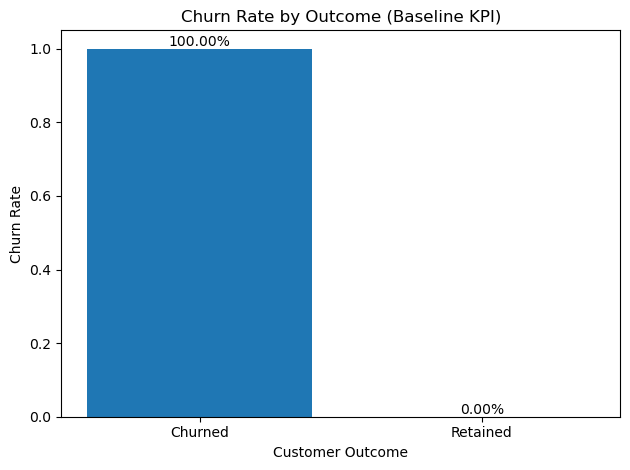

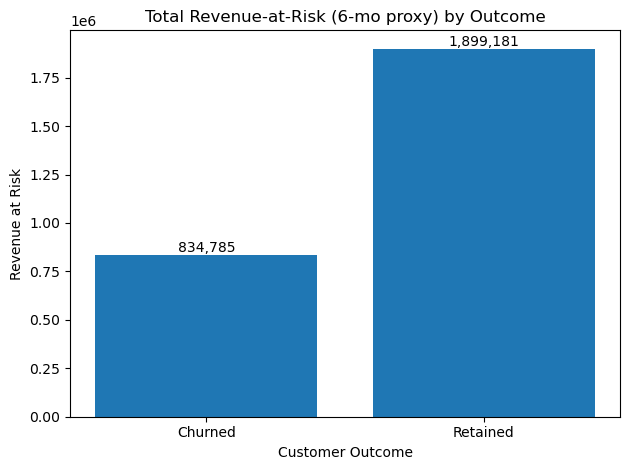

In [51]:
# -----------------------------
kpi = df.groupby("churn_label").agg(
    customers=("customerID", "count"),
    avg_arpu=("arpu", "mean"),
    avg_ltv=("estimated_ltv", "mean"),
    total_revenue_at_risk=("revenue_at_risk", "sum"),
    churn_rate=("churn_flag", "mean")
).reset_index()

plt.figure()
plt.bar(kpi["churn_label"], kpi["churn_rate"])
plt.title("Churn Rate by Outcome (Baseline KPI)")
plt.xlabel("Customer Outcome")
plt.ylabel("Churn Rate")
for i, v in enumerate(kpi["churn_rate"].values):
    plt.text(i, v, f"{v:.2%}", ha="center", va="bottom")
plt.tight_layout()
plt.show()

plt.figure()
plt.bar(kpi["churn_label"], kpi["total_revenue_at_risk"])
plt.title("Total Revenue-at-Risk (6-mo proxy) by Outcome")
plt.xlabel("Customer Outcome")
plt.ylabel("Revenue at Risk")
for i, v in enumerate(kpi["total_revenue_at_risk"].values):
    plt.text(i, v, f"{v:,.0f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()


# ARPU distribution by Churn

/var/folders/v_/wt___8bn2w96qll7bdb9csb00000gn/T/ipykernel_20142/820691942.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([retained_arpu, churned_arpu], labels=["Retained", "Churned"])


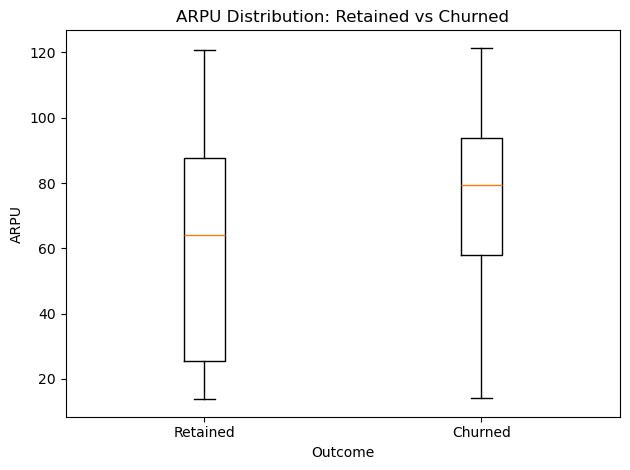

In [53]:
retained_arpu = df.loc[df["churn_flag"] == 0, "arpu"].dropna()
churned_arpu  = df.loc[df["churn_flag"] == 1, "arpu"].dropna()

plt.figure()
plt.boxplot([retained_arpu, churned_arpu], labels=["Retained", "Churned"])
plt.title("ARPU Distribution: Retained vs Churned")
plt.xlabel("Outcome")
plt.ylabel("ARPU")
plt.tight_layout()
plt.show();

# Revenue-at-risk concentration: Top 10 segments by PaymentMethod

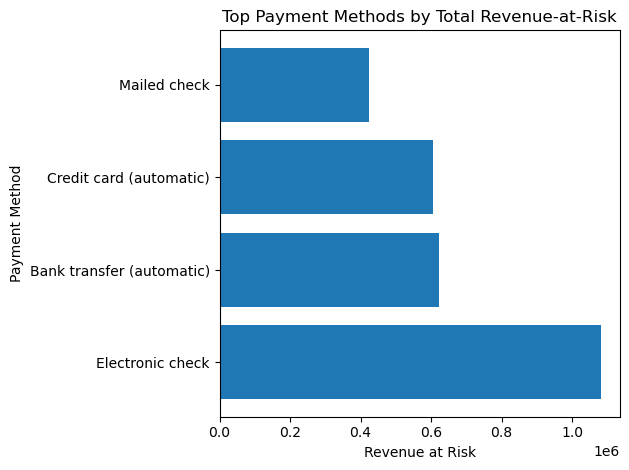

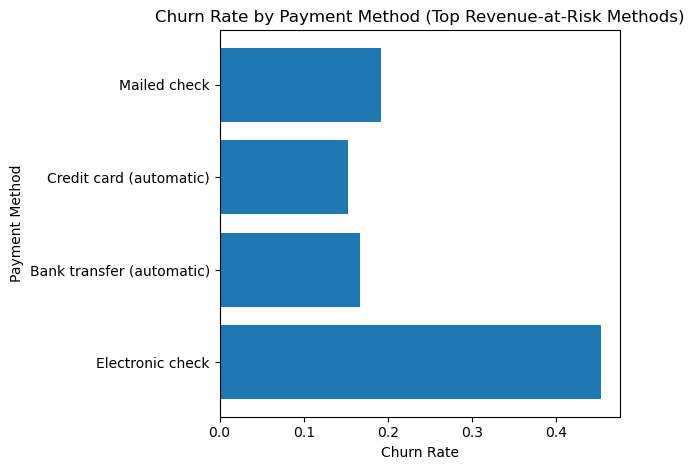

In [54]:
seg_pay = (df.groupby("PaymentMethod")
             .agg(customers=("customerID", "count"),
                  churn_rate=("churn_flag", "mean"),
                  revenue_at_risk=("revenue_at_risk", "sum"))
             .sort_values("revenue_at_risk", ascending=False)
             .head(10)
          )

plt.figure()
plt.barh(seg_pay.index.astype(str), seg_pay["revenue_at_risk"])
plt.title("Top Payment Methods by Total Revenue-at-Risk")
plt.xlabel("Revenue at Risk")
plt.ylabel("Payment Method")
plt.tight_layout()
plt.show()

plt.figure()
plt.barh(seg_pay.index.astype(str), seg_pay["churn_rate"])
plt.title("Churn Rate by Payment Method (Top Revenue-at-Risk Methods)")
plt.xlabel("Churn Rate")
plt.ylabel("Payment Method")
plt.tight_layout()
plt.show()


# Contract + Tenure segment: churn heat

/var/folders/v_/wt___8bn2w96qll7bdb9csb00000gn/T/ipykernel_20142/2718057383.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seg_ct = (df.groupby(["Contract", "tenure_segment"])


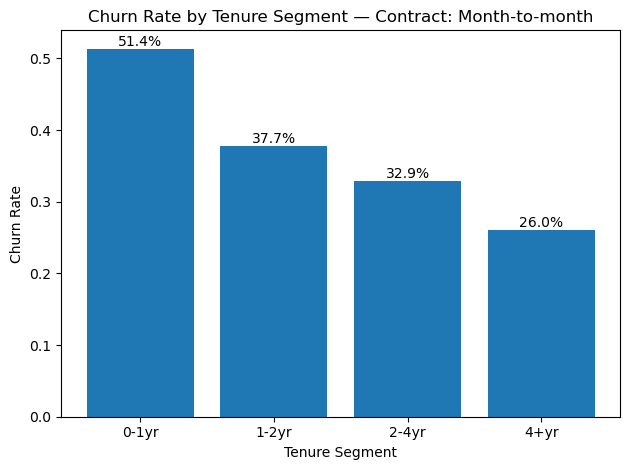

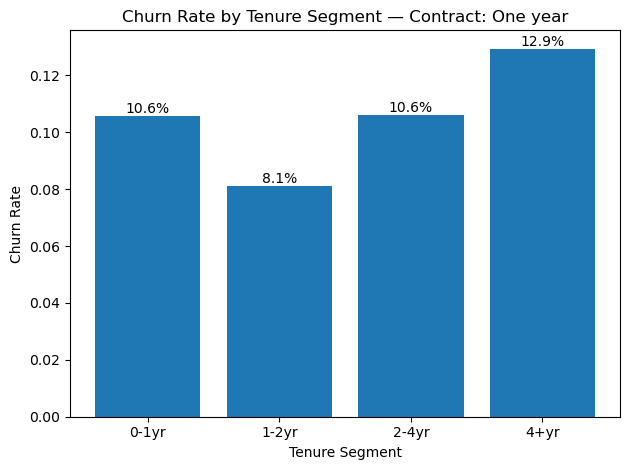

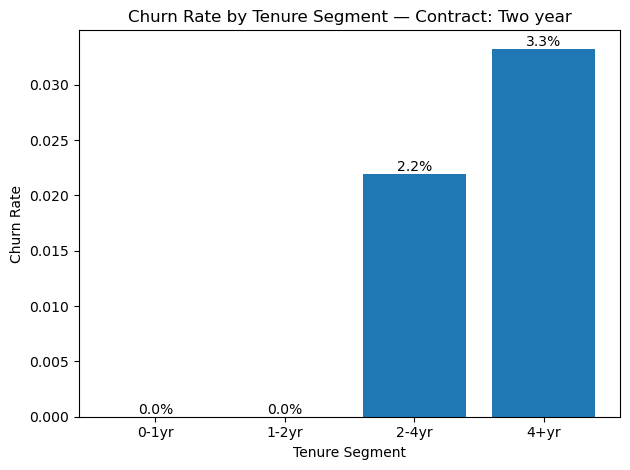

In [55]:
seg_ct = (df.groupby(["Contract", "tenure_segment"])
            .agg(customers=("customerID", "count"),
                 churn_rate=("churn_flag", "mean"))
            .reset_index()
         )

# Sort tenure segments if they exist
if "tenure_segment" in seg_ct.columns:
    seg_ct["tenure_segment"] = seg_ct["tenure_segment"].astype(str)

contracts = seg_ct["Contract"].dropna().unique().tolist()

for c in contracts:
    sub = seg_ct[seg_ct["Contract"] == c].sort_values("tenure_segment")
    plt.figure()
    plt.bar(sub["tenure_segment"].astype(str), sub["churn_rate"])
    plt.title(f"Churn Rate by Tenure Segment — Contract: {c}")
    plt.xlabel("Tenure Segment")
    plt.ylabel("Churn Rate")
    for i, v in enumerate(sub["churn_rate"].values):
        plt.text(i, v, f"{v:.1%}", ha="center", va="bottom")
    plt.tight_layout()
    plt.show()


# Bundle strength: churn rate by total_services

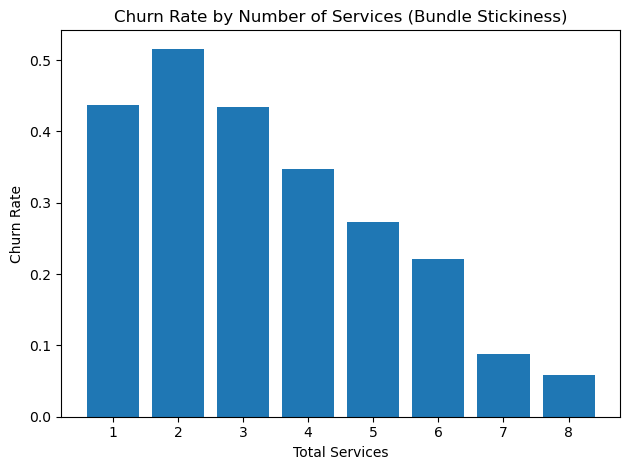

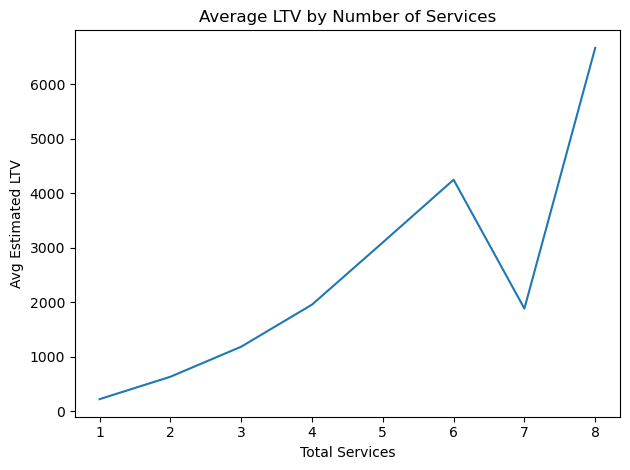

In [56]:
bundle = (df.groupby("total_services")
            .agg(customers=("customerID", "count"),
                 churn_rate=("churn_flag", "mean"),
                 avg_ltv=("estimated_ltv", "mean"))
            .reset_index()
            .sort_values("total_services")
         )

plt.figure()
plt.bar(bundle["total_services"].astype(int), bundle["churn_rate"])
plt.title("Churn Rate by Number of Services (Bundle Stickiness)")
plt.xlabel("Total Services")
plt.ylabel("Churn Rate")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(bundle["total_services"].astype(int), bundle["avg_ltv"])
plt.title("Average LTV by Number of Services")
plt.xlabel("Total Services")
plt.ylabel("Avg Estimated LTV")
plt.tight_layout()
plt.show()

#  High value vs not: churn rate + revenue at risk

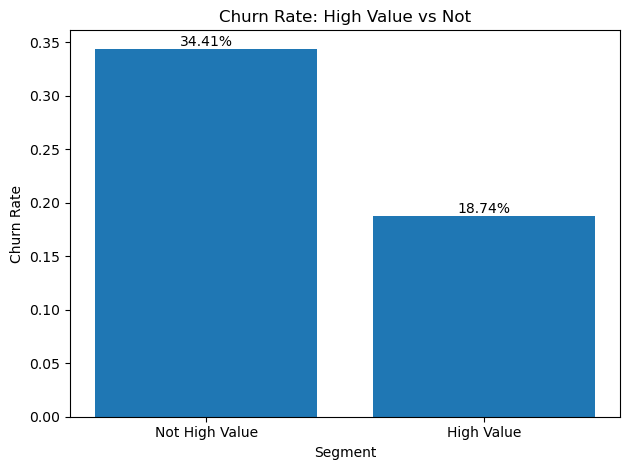

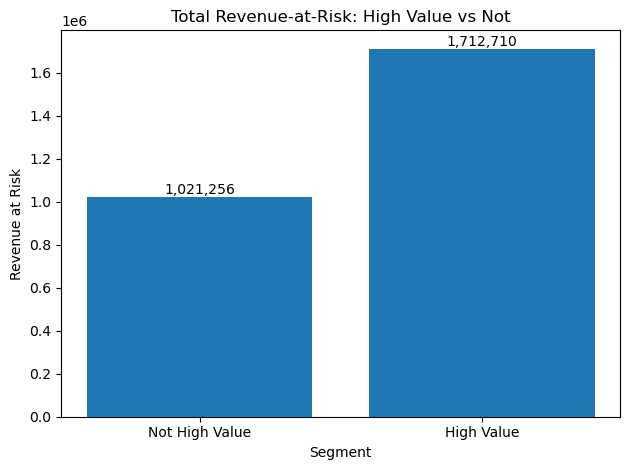

In [57]:
hv = (df.groupby("high_value_flag")
        .agg(customers=("customerID", "count"),
             churn_rate=("churn_flag", "mean"),
             total_revenue_at_risk=("revenue_at_risk", "sum"),
             avg_ltv=("estimated_ltv", "mean"))
        .reset_index()
     )

hv["segment"] = hv["high_value_flag"].map({False: "Not High Value", True: "High Value"}).fillna(hv["high_value_flag"].astype(str))

plt.figure()
plt.bar(hv["segment"], hv["churn_rate"])
plt.title("Churn Rate: High Value vs Not")
plt.xlabel("Segment")
plt.ylabel("Churn Rate")
for i, v in enumerate(hv["churn_rate"].values):
    plt.text(i, v, f"{v:.2%}", ha="center", va="bottom")
plt.tight_layout()
plt.show()

plt.figure()
plt.bar(hv["segment"], hv["total_revenue_at_risk"])
plt.title("Total Revenue-at-Risk: High Value vs Not")
plt.xlabel("Segment")
plt.ylabel("Revenue at Risk")
for i, v in enumerate(hv["total_revenue_at_risk"].values):
    plt.text(i, v, f"{v:,.0f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()


# Loyalty score: churn rate by loyalty decile

/var/folders/v_/wt___8bn2w96qll7bdb9csb00000gn/T/ipykernel_20142/2107522571.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loy = (tmp.groupby("loyalty_decile")


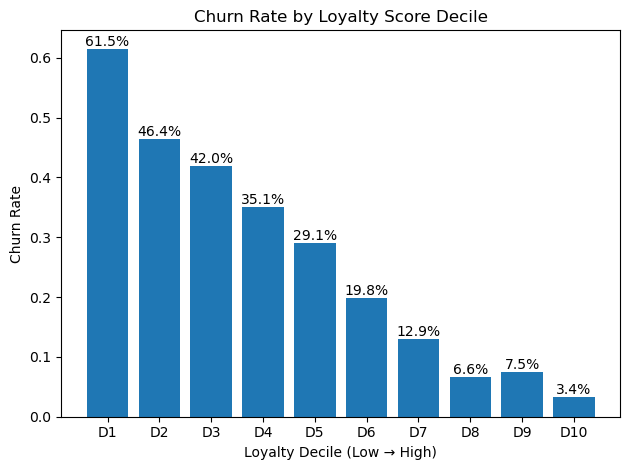

In [59]:
tmp = df[["loyalty_score", "churn_flag"]].dropna().copy()
tmp["loyalty_decile"] = pd.qcut(tmp["loyalty_score"], 10, labels=[f"D{i}" for i in range(1, 11)], duplicates="drop")

loy = (tmp.groupby("loyalty_decile")
         .agg(customers=("churn_flag", "count"),
              churn_rate=("churn_flag", "mean"))
         .reset_index()
      )

plt.figure()
plt.bar(loy["loyalty_decile"].astype(str), loy["churn_rate"])
plt.title("Churn Rate by Loyalty Score Decile")
plt.xlabel("Loyalty Decile (Low → High)")
plt.ylabel("Churn Rate")
for i, v in enumerate(loy["churn_rate"].values):
    plt.text(i, v, f"{v:.1%}", ha="center", va="bottom")
plt.tight_layout()
plt.show()

# Price sensitivity: churn rate by cost tier (if you add it) OR by MonthlyCharges quartile

/var/folders/v_/wt___8bn2w96qll7bdb9csb00000gn/T/ipykernel_20142/1045762014.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mc = (tmp.groupby("monthly_charge_quartile")


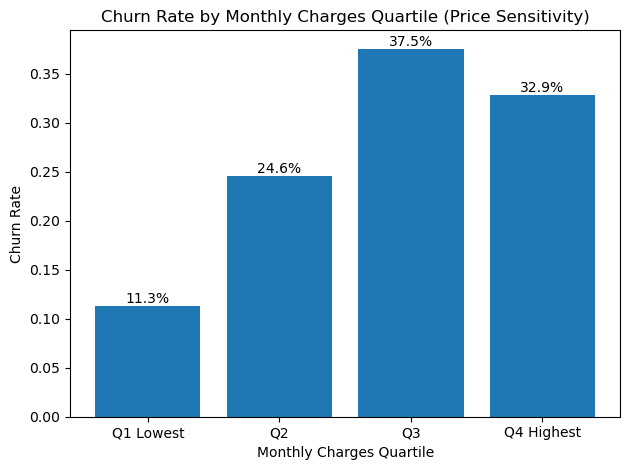

                customers  churn_rate   avg_arpu      avg_ltv  revenue_at_risk
Contract                                                                      
Month-to-month       3875    0.427097  66.376101  1370.115032        1543764.9
Two year             1685    0.028487  60.903915  3728.758249         615419.7
One year             1472    0.112772  65.108057  3031.887262         574781.4


In [60]:
tmp = df[["MonthlyCharges", "churn_flag"]].dropna().copy()
tmp["monthly_charge_quartile"] = pd.qcut(tmp["MonthlyCharges"], 4, labels=["Q1 Lowest", "Q2", "Q3", "Q4 Highest"], duplicates="drop")

mc = (tmp.groupby("monthly_charge_quartile")
        .agg(customers=("churn_flag", "count"),
             churn_rate=("churn_flag", "mean"))
        .reset_index()
     )

plt.figure()
plt.bar(mc["monthly_charge_quartile"].astype(str), mc["churn_rate"])
plt.title("Churn Rate by Monthly Charges Quartile (Price Sensitivity)")
plt.xlabel("Monthly Charges Quartile")
plt.ylabel("Churn Rate")
for i, v in enumerate(mc["churn_rate"].values):
    plt.text(i, v, f"{v:.1%}", ha="center", va="bottom")
plt.tight_layout()
plt.show()

# -----------------------------
# 9) Quick executive table (optional print)
# -----------------------------
exec_table = (df.groupby(["Contract"])
                .agg(customers=("customerID", "count"),
                     churn_rate=("churn_flag", "mean"),
                     avg_arpu=("arpu", "mean"),
                     avg_ltv=("estimated_ltv", "mean"),
                     revenue_at_risk=("revenue_at_risk", "sum"))
                .sort_values("revenue_at_risk", ascending=False))

print(exec_table)

# Churn Distribution

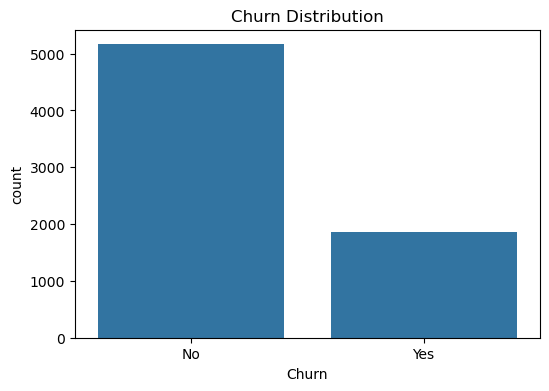

Churn Rate: 0.26578498293515357


In [61]:
plt.figure(figsize=(6,4))
sns.countplot(x="Churn", data=df)
plt.title("Churn Distribution")
plt.show()

print("Churn Rate:", df["churn_flag"].mean())

# ARPU Distribution (Churn vs Retain)

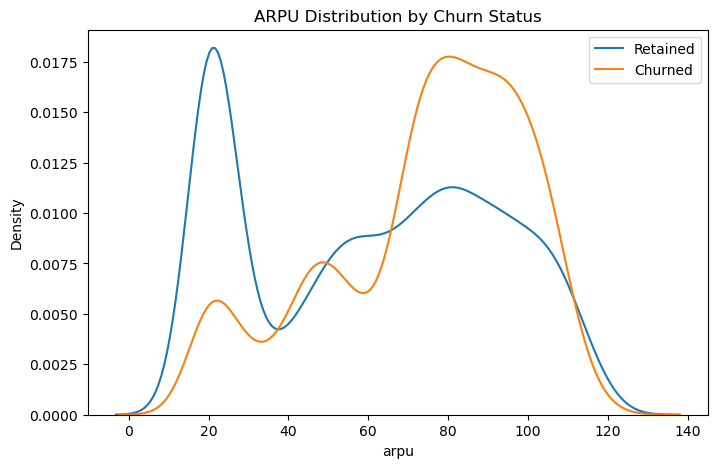

In [62]:
plt.figure(figsize=(8,5))
sns.kdeplot(df[df["churn_flag"]==0]["arpu"], label="Retained")
sns.kdeplot(df[df["churn_flag"]==1]["arpu"], label="Churned")
plt.title("ARPU Distribution by Churn Status")
plt.legend()
plt.show()

# Tenure Distribution


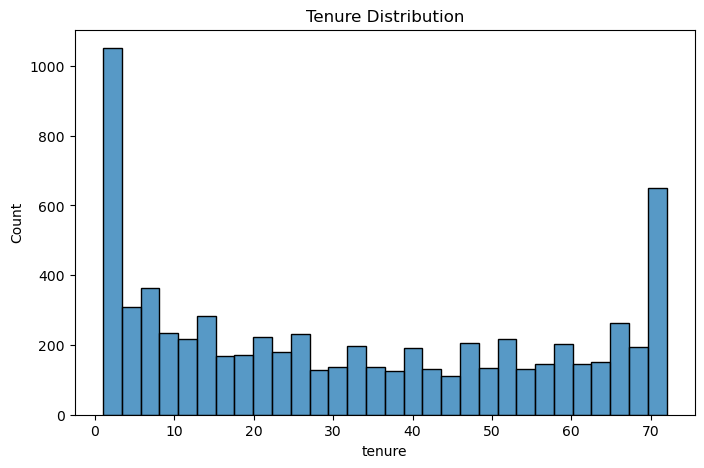

In [63]:
plt.figure(figsize=(8,5))
sns.histplot(df["tenure"], bins=30)
plt.title("Tenure Distribution")
plt.show()

# Hypothesis Testing
We test whether key variables differ significantly between churned vs retained customers.
T-Test: ARPU Difference
- H₀: ARPU is same for churned and retained

In [65]:
df["churn_flag"] = (df["Churn"] == "Yes").astype(int)

# Ensure numeric columns
numeric_cols = ["tenure","MonthlyCharges","TotalCharges",
                "estimated_ltv","arpu","revenue_at_risk",
                "bundle_strength","price_to_tenure_ratio",
                "loyalty_score"]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

In [66]:
retained = df[df["churn_flag"]==0]["arpu"]
churned = df[df["churn_flag"]==1]["arpu"]

t_stat, p_val = stats.ttest_ind(retained, churned, nan_policy='omit')

print("T-stat:", t_stat)
print("P-value:", p_val)

T-stat: -16.406338287786962
P-value: 2.165685563382444e-59


In [67]:
stats.ttest_ind(
    df[df["churn_flag"]==0]["tenure"],
    df[df["churn_flag"]==1]["tenure"],
    nan_policy='omit'
)

TtestResult(statistic=np.float64(31.741289063447653), pvalue=np.float64(9.437650217574845e-207), df=np.float64(7030.0))

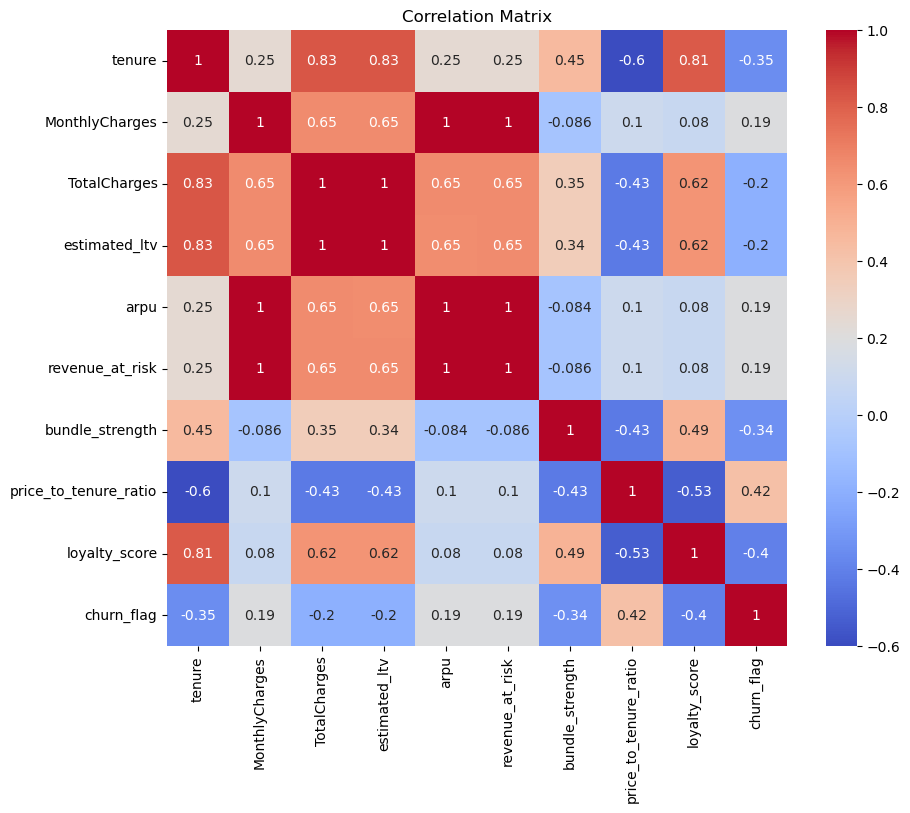

In [68]:
plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_cols + ["churn_flag"]].corr(),
            annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Categorical Statistical Tests

### Chi-Square Test (Contract vs Churn)


In [69]:
cont_table = pd.crosstab(df["Contract"], df["Churn"])
chi2, p, dof, expected = stats.chi2_contingency(cont_table)

print("Chi-square p-value:", p)

Chi-square p-value: 7.326182186265472e-257


### Payment Method vs Churn


In [70]:
cont_table = pd.crosstab(df["PaymentMethod"], df["Churn"])
stats.chi2_contingency(cont_table)

Chi2ContingencyResult(statistic=np.float64(645.4299001234638), pvalue=np.float64(1.4263098511063342e-139), dof=3, expected_freq=array([[1132.15955631,  409.84044369],
       [1116.74104096,  404.25895904],
       [1736.41851536,  628.58148464],
       [1177.68088737,  426.31911263]]))

# Segment Analysis

### Churn by Contract


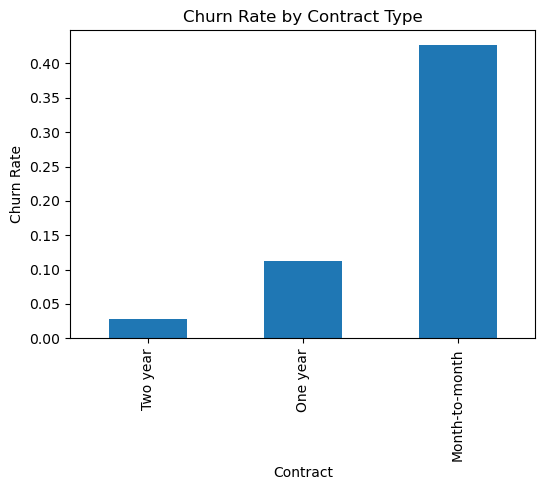

In [71]:
contract_churn = df.groupby("Contract")["churn_flag"].mean().sort_values()

contract_churn.plot(kind="bar", figsize=(6,4))
plt.title("Churn Rate by Contract Type")
plt.ylabel("Churn Rate")
plt.show()

### Churn by Total Services (Bundle Stickiness)


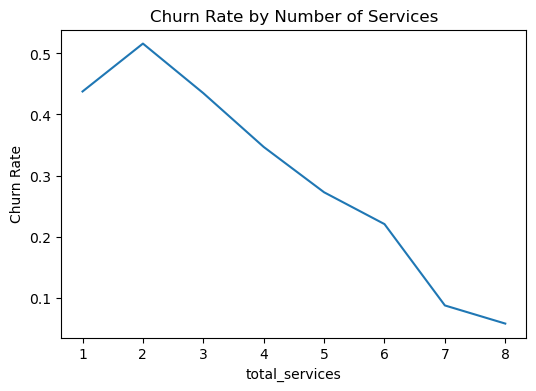

In [72]:
bundle = df.groupby("total_services")["churn_flag"].mean()

bundle.plot(figsize=(6,4))
plt.title("Churn Rate by Number of Services")
plt.ylabel("Churn Rate")
plt.show()

### Revenue at Risk by Contract


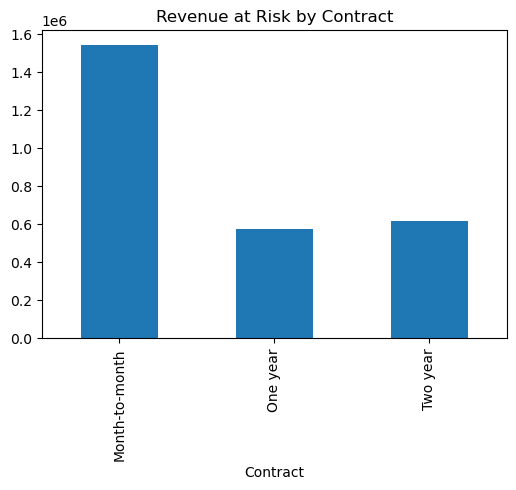

In [73]:
rev_risk = df.groupby("Contract")["revenue_at_risk"].sum()

rev_risk.plot(kind="bar", figsize=(6,4))
plt.title("Revenue at Risk by Contract")
plt.show()

# Predict churn probability + expected revenue loss (customer-level)

In [75]:
H = 6  # change to 12 for a 12-month forecast

# Expected months lost if churn occurs during horizon (simple assumption)
EXPECTED_LOST_MONTHS = H / 2

# ---------------------------
# 1) Features + model pipeline
# ---------------------------
target = "churn_flag"

drop_cols = ["customerID", "Churn", "churn_flag"]  # drop non-features
X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df[target]

# Identify column types
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

model = LogisticRegression(max_iter=2000, class_weight="balanced")

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", model)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

clf.fit(X_train, y_train)

# Evaluate
proba_test = clf.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, proba_test))
print("Avg Precision (PR AUC):", average_precision_score(y_test, proba_test))

# ---------------------------
# 2) Predict churn probability for all customers
# ---------------------------
df["p_churn"] = clf.predict_proba(X)[:, 1]

# ---------------------------
# 3) Revenue loss forecasting
# ---------------------------
# Simple revenue projection from MonthlyCharges (you can swap in ARPU if you prefer)
df["projected_revenue_H"] = df["MonthlyCharges"] * H

# Expected revenue loss:
# expected_loss = P(churn) * MonthlyCharges * expected_lost_months
df["expected_revenue_loss"] = df["p_churn"] * df["MonthlyCharges"] * EXPECTED_LOST_MONTHS

# Optional: expected profit loss if you assume a gross margin
GROSS_MARGIN = 1.0  # set to e.g., 0.6 if you want profit impact
df["expected_profit_loss"] = df["expected_revenue_loss"] * GROSS_MARGIN

df[["customerID","p_churn","MonthlyCharges","expected_revenue_loss"]].head()

ROC AUC: 1.0
Avg Precision (PR AUC): 0.9999999999999999


,customerID,p_churn,MonthlyCharges,expected_revenue_loss
0,7590-VHVEG,0.005928,29.85,0.530897
1,5575-GNVDE,0.001118,56.95,0.190965
2,3668-QPYBK,0.997439,53.85,161.136303
3,7795-CFOCW,0.000987,42.30,0.125297
4,9237-HQITU,0.999026,70.70,211.893424


# Total forecasted loss + concentration (Pareto)

Total expected revenue loss over next 6 months: 418,955


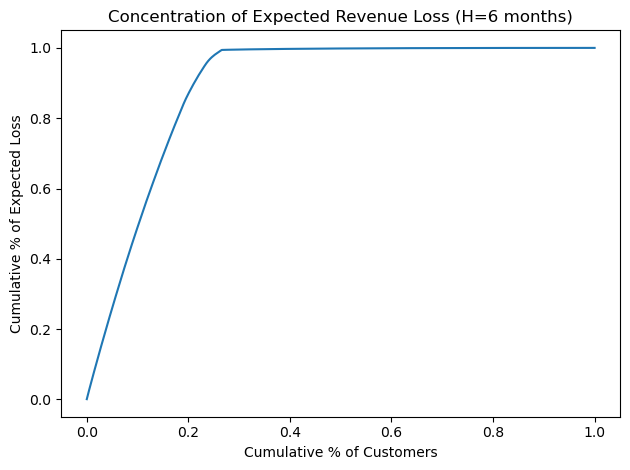

In [76]:
total_loss = df["expected_revenue_loss"].sum()
print(f"Total expected revenue loss over next {H} months: {total_loss:,.0f}")

# Pareto curve: what % of customers drive what % of expected loss?
pareto = df[["customerID","expected_revenue_loss"]].sort_values("expected_revenue_loss", ascending=False).reset_index(drop=True)
pareto["cum_loss"] = pareto["expected_revenue_loss"].cumsum()
pareto["cum_loss_pct"] = pareto["cum_loss"] / pareto["expected_revenue_loss"].sum()
pareto["cum_cust_pct"] = (pareto.index + 1) / len(pareto)

plt.figure()
plt.plot(pareto["cum_cust_pct"], pareto["cum_loss_pct"])
plt.title(f"Concentration of Expected Revenue Loss (H={H} months)")
plt.xlabel("Cumulative % of Customers")
plt.ylabel("Cumulative % of Expected Loss")
plt.tight_layout()
plt.show()

# Top 20 customers by expected loss (action list)


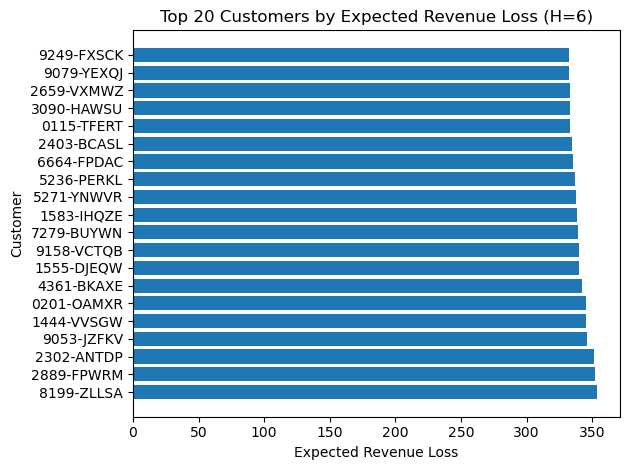

,customerID,p_churn,MonthlyCharges,Contract,PaymentMethod,InternetService,expected_revenue_loss
5127,8199-ZLLSA,0.995531,118.35,One year,Bank transfer (automatic),Fiber optic,353.463455
4610,2889-FPWRM,0.995445,117.80,One year,Bank transfer (automatic),Fiber optic,351.790209
4875,2302-ANTDP,0.997624,117.45,Month-to-month,Electronic check,Fiber optic,351.512859
6289,9053-JZFKV,0.992929,116.20,Two year,Credit card (automatic),Fiber optic,346.135150
6537,1444-VVSGW,0.995063,115.65,One year,Credit card (automatic),Fiber optic,345.237243
1306,0201-OAMXR,0.995107,115.55,One year,Credit card (automatic),Fiber optic,344.953931
1077,4361-BKAXE,0.997113,114.50,Month-to-month,Bank transfer (automatic),Fiber optic,342.508227
6038,1555-DJEQW,0.992272,114.20,Two year,Bank transfer (automatic),Fiber optic,339.952425
1673,9158-VCTQB,0.997148,113.60,Month-to-month,Bank transfer (automatic),Fiber optic,339.828208
1770,7279-BUYWN,0.998256,113.20,Month-to-month,Electronic check,Fiber optic,339.007697


In [77]:
top20 = df.sort_values("expected_revenue_loss", ascending=False).head(20)

plt.figure()
plt.barh(top20["customerID"].astype(str), top20["expected_revenue_loss"])
plt.title(f"Top 20 Customers by Expected Revenue Loss (H={H})")
plt.xlabel("Expected Revenue Loss")
plt.ylabel("Customer")
plt.tight_layout()
plt.show()

top20[["customerID","p_churn","MonthlyCharges","Contract","PaymentMethod","InternetService","expected_revenue_loss"]]

# Segment forecasting (Contract, PaymentMethod, InternetService, etc.)

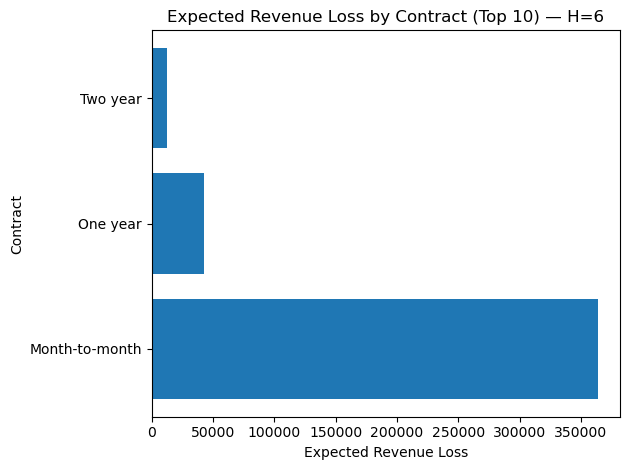

,customers,avg_p_churn,avg_monthly,expected_loss
Contract,,,,
Month-to-month,3875,0.428448,66.398490,363638.610671
One year,1472,0.113649,65.079416,42625.583653
Two year,1685,0.029026,60.872374,12690.893682


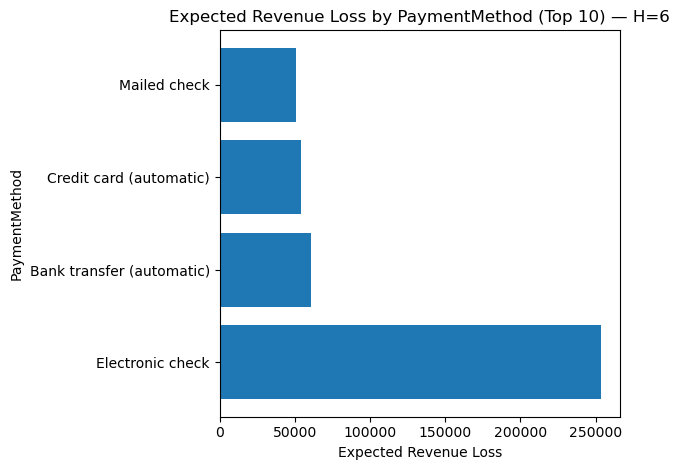

,customers,avg_p_churn,avg_monthly,expected_loss
PaymentMethod,,,,
Electronic check,2365,0.454189,76.255814,253608.424583
Bank transfer (automatic),1542,0.168125,67.205577,60553.524996
Credit card (automatic),1521,0.153459,66.519264,54142.411657
Mailed check,1604,0.193031,43.958354,50650.726769


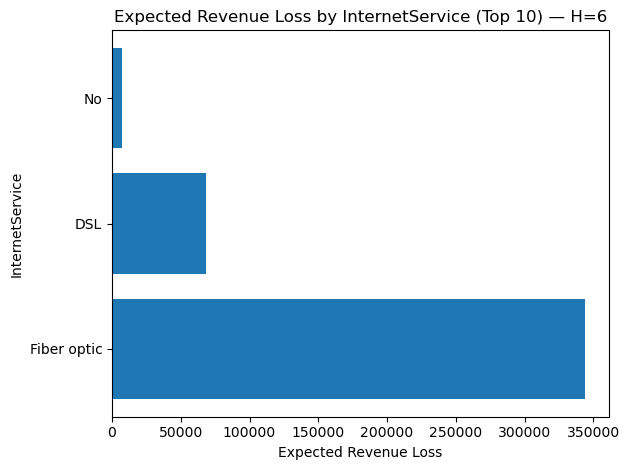

,customers,avg_p_churn,avg_monthly,expected_loss
InternetService,,,,
Fiber optic,3096,0.420247,91.500129,344000.869207
DSL,2416,0.190967,58.088017,67987.929567
No,1520,0.074984,21.076283,6966.289232


In [78]:
def segment_loss_view(df, col, top_n=10):
    seg = (df.groupby(col)
             .agg(customers=("customerID","count"),
                  avg_p_churn=("p_churn","mean"),
                  avg_monthly=("MonthlyCharges","mean"),
                  expected_loss=("expected_revenue_loss","sum"))
             .sort_values("expected_loss", ascending=False)
             .head(top_n)
          )
    return seg

for col in ["Contract", "PaymentMethod", "InternetService"]:
    seg = segment_loss_view(df, col, top_n=10)
    plt.figure()
    plt.barh(seg.index.astype(str), seg["expected_loss"])
    plt.title(f"Expected Revenue Loss by {col} (Top 10) — H={H}")
    plt.xlabel("Expected Revenue Loss")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()
    display(seg)

# “Forecast buckets” for planning: risk tiers & expected loss tiers

/var/folders/v_/wt___8bn2w96qll7bdb9csb00000gn/T/ipykernel_20142/2681719371.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tier = (df.groupby("risk_tier")


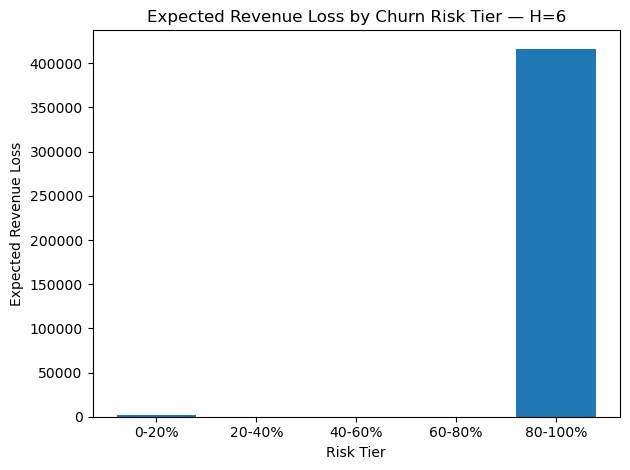

,risk_tier,customers,avg_p_churn,expected_loss
0,0-20%,5163,0.002254,2438.654880
1,20-40%,0,NaN,0.000000
2,40-60%,0,NaN,0.000000
3,60-80%,0,NaN,0.000000
4,80-100%,1869,0.997752,416516.433126


In [79]:
# Risk tiers
df["risk_tier"] = pd.cut(
    df["p_churn"],
    bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
    labels=["0-20%","20-40%","40-60%","60-80%","80-100%"],
    include_lowest=True
)

tier = (df.groupby("risk_tier")
          .agg(customers=("customerID","count"),
               avg_p_churn=("p_churn","mean"),
               expected_loss=("expected_revenue_loss","sum"))
          .reset_index()
)

plt.figure()
plt.bar(tier["risk_tier"].astype(str), tier["expected_loss"])
plt.title(f"Expected Revenue Loss by Churn Risk Tier — H={H}")
plt.xlabel("Risk Tier")
plt.ylabel("Expected Revenue Loss")
plt.tight_layout()
plt.show()

tier

# Monthly “time series” forecast

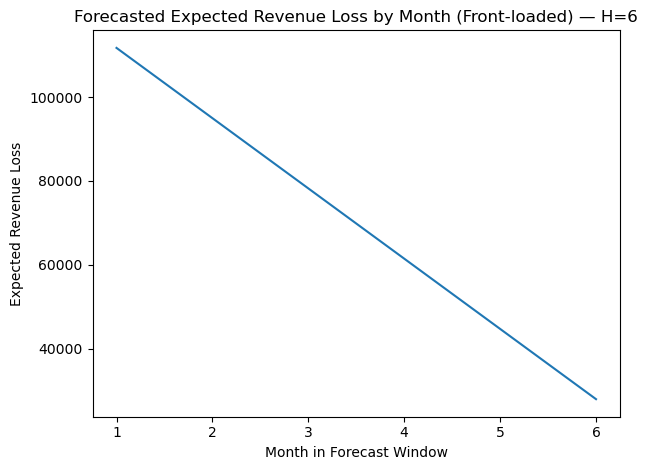

In [80]:
months = np.arange(1, H+1)

# Front-loaded weights (more churn earlier)
weights = np.linspace(1.6, 0.4, H)
weights = weights / weights.sum()

monthly_loss = df["expected_revenue_loss"].sum() * weights

plt.figure()
plt.plot(months, monthly_loss)
plt.title(f"Forecasted Expected Revenue Loss by Month (Front-loaded) — H={H}")
plt.xlabel("Month in Forecast Window")
plt.ylabel("Expected Revenue Loss")
plt.tight_layout()
plt.show()

# Prepare data + fit Cox model

In [83]:
df_surv = df.copy()

# Event indicator: 1 if churned, 0 if censored (still active)
df_surv["event"] = (df_surv["Churn"].astype(str).str.strip().str.lower() == "yes").astype(int)

# Duration in months
df_surv["duration"] = pd.to_numeric(df_surv["tenure"], errors="coerce")


In [84]:
# Clean numeric columns (TotalCharges often object)
df_surv["TotalCharges"] = pd.to_numeric(df_surv["TotalCharges"], errors="coerce").fillna(0)
df_surv["MonthlyCharges"] = pd.to_numeric(df_surv["MonthlyCharges"], errors="coerce")


In [86]:
# IMPORTANT: drop TotalCharges to avoid near-perfect collinearity with duration + MonthlyCharges
# df_surv["TotalCharges"] = pd.to_numeric(df_surv["TotalCharges"], errors="coerce").fillna(0)

covariates = [
    "MonthlyCharges",
    "SeniorCitizen",
    "Partner",
    "Dependents",
    "PhoneService",
    "InternetService",
    "OnlineSecurity",
    "TechSupport",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod",
    "total_services",
    "loyalty_score",
]

data = df_surv[["duration", "event"] + covariates].dropna(subset=["duration", "event"])

yn_cols = ["Partner","Dependents","PhoneService","OnlineSecurity","TechSupport","PaperlessBilling"]
for c in yn_cols:
    data[c] = data[c].astype(str).str.strip().str.lower().map({"yes":1, "no":0})

cat_cols = ["InternetService","Contract","PaymentMethod"]
data = pd.get_dummies(data, columns=cat_cols, drop_first=True)

# Ensure numeric & clean infinities
for c in data.columns:
    if c not in ["duration","event"]:
        data[c] = pd.to_numeric(data[c], errors="coerce")
data = data.replace([np.inf, -np.inf], np.nan).dropna()

# Drop low-variance columns (all same value)
low_var = [c for c in data.columns if c not in ["duration","event"] and data[c].nunique() <= 1]
data = data.drop(columns=low_var)

# Standardize numeric columns (helps stability)
num_cols = ["MonthlyCharges","total_services","loyalty_score"]
for c in num_cols:
    if c in data.columns:
        data[c] = (data[c] - data[c].mean()) / (data[c].std(ddof=0) + 1e-9)

# Fit Cox PH with stronger penalization
cph = CoxPHFitter(penalizer=0.2)
cph.fit(data, duration_col="duration", event_col="event")

print(cph.summary[["coef","exp(coef)","p"]].sort_values("exp(coef)", ascending=False).head(15))

                                           coef  exp(coef)             p
covariate                                                               
InternetService_Fiber optic            0.256620   1.292554  3.441224e-08
PaymentMethod_Electronic check         0.140232   1.150541  1.369198e-03
PaperlessBilling                       0.129750   1.138543  2.370950e-03
PhoneService                           0.125586   1.133813  5.276354e-02
PaymentMethod_Mailed check             0.031225   1.031717  5.917624e-01
SeniorCitizen                         -0.002541   0.997463  9.548740e-01
MonthlyCharges                        -0.054037   0.947397  2.828042e-02
PaymentMethod_Credit card (automatic) -0.075532   0.927250  1.595803e-01
Dependents                            -0.125061   0.882443  8.313693e-03
total_services                        -0.260596   0.770592  4.420146e-28
TechSupport                           -0.280498   0.755408  3.566042e-10
Partner                               -0.328096   0

# Validate model

In [87]:
# Cross-validated concordance index (higher is better; ~0.5 is random)
scores = k_fold_cross_validation(cph, data, duration_col="duration", event_col="event", k=5, scoring_method="concordance_index")
print("CV Concordance:", np.mean(scores), "+/-", np.std(scores))

CV Concordance: 0.8667006256403866 +/- 0.0075207989452426


# Survival curves by segment (e.g., Contract)

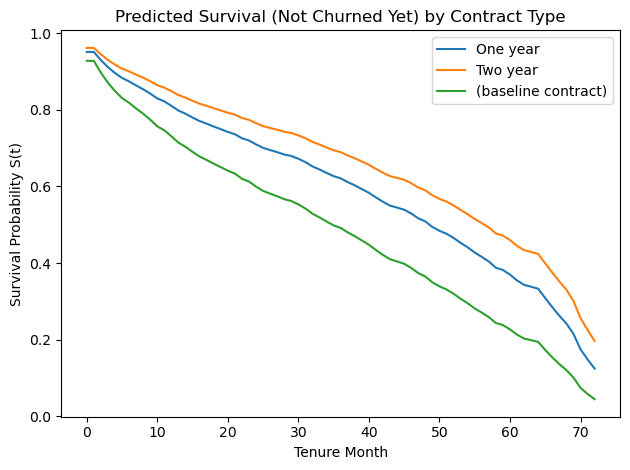

In [88]:
# Build representative profiles for each contract type:
# We'll create "typical" customer using medians/modes, then toggle contract dummies.
base = data.drop(columns=["duration","event"]).median(numeric_only=True).to_frame().T

# Identify contract dummy columns
contract_cols = [c for c in base.columns if c.startswith("Contract_")]

# If there are no contract dummies (unlikely), skip
if contract_cols:
    plt.figure()
    for cc in contract_cols:
        profile = base.copy()
        # set all contract dummies 0, then set selected 1
        for k in contract_cols:
            profile[k] = 0
        profile[cc] = 1

        sf = cph.predict_survival_function(profile, times=np.arange(0, 73))  # 0..72 months
        plt.plot(sf.index, sf.values.flatten(), label=cc.replace("Contract_",""))

    # also include baseline = drop_first category (all zeros)
    profile0 = base.copy()
    for k in contract_cols:
        profile0[k] = 0
    sf0 = cph.predict_survival_function(profile0, times=np.arange(0, 73))
    plt.plot(sf0.index, sf0.values.flatten(), label="(baseline contract)")

    plt.title("Predicted Survival (Not Churned Yet) by Contract Type")
    plt.xlabel("Tenure Month")
    plt.ylabel("Survival Probability S(t)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# “Which month churn is likely to happen?” (median churn month)

In [89]:
def median_churn_month(survival_series: pd.Series) -> float:
    # survival_series indexed by time
    below = survival_series[survival_series <= 0.5]
    if below.empty:
        return np.nan
    return float(below.index.min())

# Example: median churn month for baseline profile
times = np.arange(0, 73)
sf_base = cph.predict_survival_function(base, times=times).iloc[:,0]
print("Median predicted churn month (base profile):", median_churn_month(sf_base))

Median predicted churn month (base profile): 35.0


# Convert survival curve → month-by-month churn + revenue loss forecast

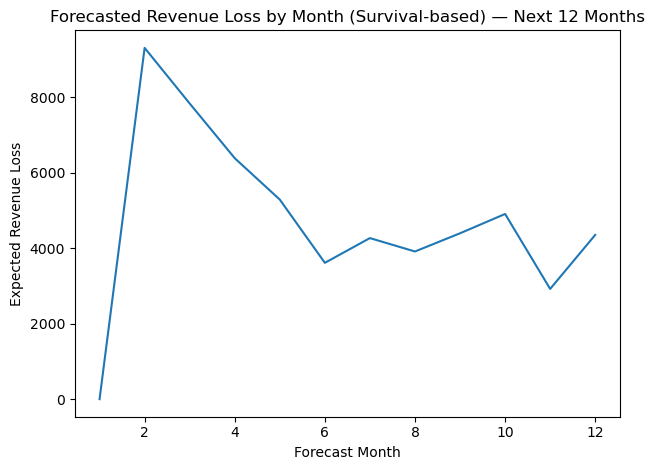

Total expected revenue loss (survival-based): 57148.94831673576


In [90]:
H = 12  # forecast next 12 months
times = np.arange(0, H+1)

# Use model covariates only (same columns as cph)
X = data.drop(columns=["duration","event"]).copy()

# Predicted survival for each customer at t=0..H
# This returns a dataframe: rows=times, cols=customers (can be large; sample if needed)
# For big data, do it in batches. Telco dataset is usually fine.
S = cph.predict_survival_function(X, times=times)

# Compute monthly churn probability mass for month 1..H:
# p_churn_m = S(m-1) - S(m)
S_shift = S.shift(1).fillna(1.0)  # S(0-1)=1 baseline at time 0
P_month = (S_shift - S).iloc[1:]  # months 1..H

# Customer monthly charges aligned to columns
monthly = df_surv.loc[data.index, "MonthlyCharges"].astype(float)

# Expected revenue loss per month per customer
rev_loss_month = P_month.mul(monthly.values, axis=1)  # rows=month, cols=customer

# Total forecasted revenue loss by month (portfolio-level curve)
portfolio_loss_by_month = rev_loss_month.sum(axis=1)

plt.figure()
plt.plot(portfolio_loss_by_month.index, portfolio_loss_by_month.values)
plt.title(f"Forecasted Revenue Loss by Month (Survival-based) — Next {H} Months")
plt.xlabel("Forecast Month")
plt.ylabel("Expected Revenue Loss")
plt.tight_layout()
plt.show()

print("Total expected revenue loss (survival-based):", portfolio_loss_by_month.sum())

# Segment-level monthly revenue loss (actionable planning)

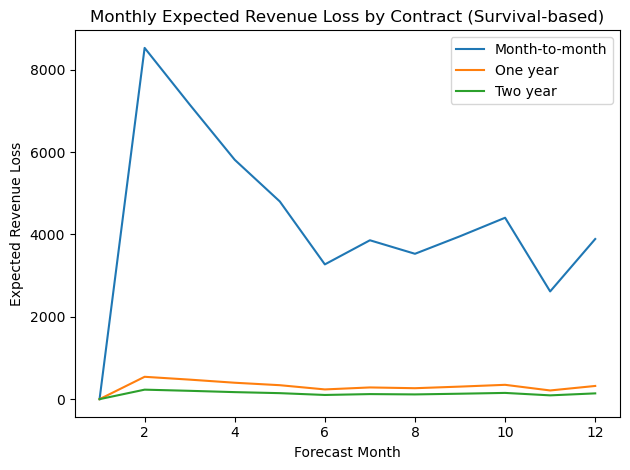

In [91]:
def segment_monthly_loss(df_original, data_model, cph, segment_col, H=12, top_n=10):
    times = np.arange(0, H+1)
    X = data_model.drop(columns=["duration","event"])
    S = cph.predict_survival_function(X, times=times)
    Pm = (S.shift(1).fillna(1.0) - S).iloc[1:]  # months 1..H

    monthly = df_original.loc[data_model.index, "MonthlyCharges"].astype(float)
    rev_loss = Pm.mul(monthly.values, axis=1)  # month x customer

    seg = df_original.loc[data_model.index, segment_col].astype(str).fillna("Unknown")
    out = {}
    for g in seg.unique():
        cols = seg[seg == g].index
        out[g] = rev_loss[cols].sum(axis=1)

    seg_df = pd.DataFrame(out)  # index=month, columns=segment values

    # Keep only top segments by total loss
    totals = seg_df.sum(axis=0).sort_values(ascending=False).head(top_n).index
    seg_df = seg_df[totals]
    return seg_df

seg_loss = segment_monthly_loss(df_surv, data, cph, "Contract", H=12, top_n=10)

plt.figure()
for col in seg_loss.columns:
    plt.plot(seg_loss.index, seg_loss[col].values, label=col)
plt.title("Monthly Expected Revenue Loss by Contract (Survival-based)")
plt.xlabel("Forecast Month")
plt.ylabel("Expected Revenue Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [94]:
df_model = df.copy()

df_model["churn_flag"] = (df_model["Churn"] == "Yes").astype(int)

# Clean TotalCharges
df_model["TotalCharges"] = pd.to_numeric(df_model["TotalCharges"], errors="coerce").fillna(0)

X = df_model.drop(columns=["customerID", "Churn", "churn_flag"])
y = df_model["churn_flag"]

In [95]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [96]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

In [97]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        use_label_encoder=False
    )
}

In [98]:
results = []

for name, model in models.items():

    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba)
    }

    results.append(metrics)

results_df = pd.DataFrame(results).sort_values("F1 Score", ascending=False)
results_df

/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:200: UserWarning: [13:53:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,1.0,1.0,1.0,1.0,1.0
1,Decision Tree,1.0,1.0,1.0,1.0,1.0
2,Random Forest,1.0,1.0,1.0,1.0,1.0
3,XGBoost,1.0,1.0,1.0,1.0,1.0


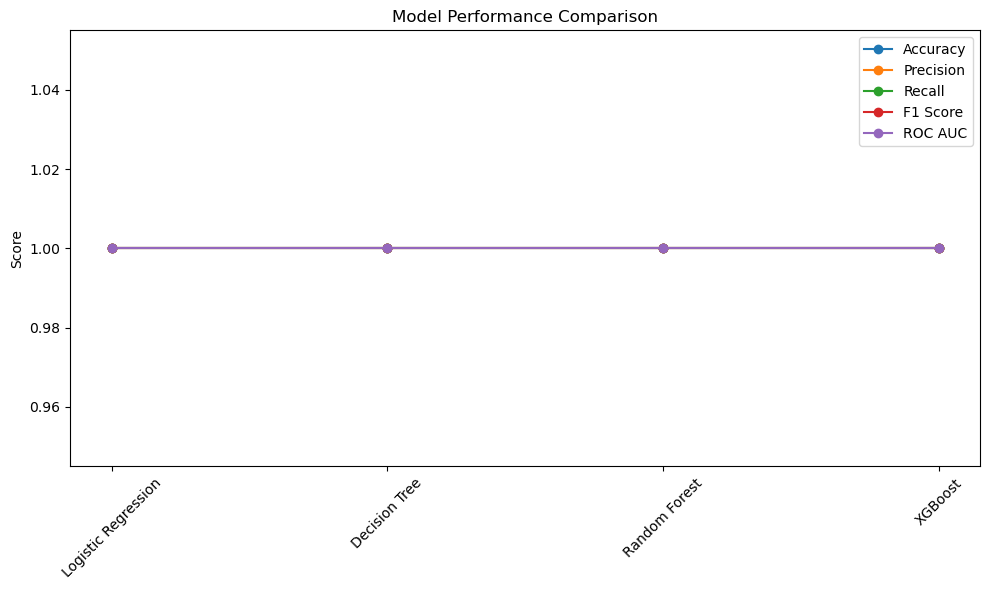

In [99]:
metrics_to_plot = ["Accuracy","Precision","Recall","F1 Score","ROC AUC"]

plt.figure(figsize=(10,6))

for metric in metrics_to_plot:
    plt.plot(results_df["Model"], results_df[metric], marker='o', label=metric)

plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Logistic Regression Feature Importance

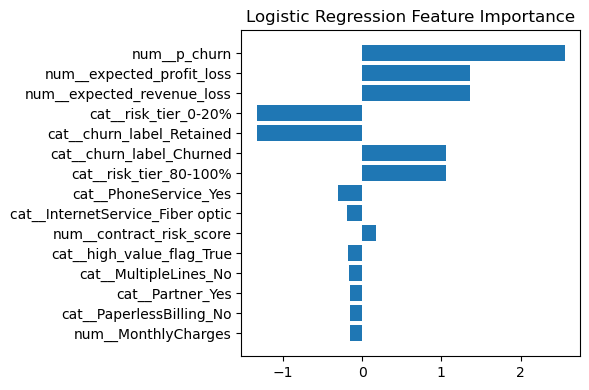

In [100]:
log_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

log_pipe.fit(X_train, y_train)

feature_names = (
    log_pipe.named_steps["preprocess"]
    .get_feature_names_out()
)

coef = log_pipe.named_steps["model"].coef_[0]

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": coef
}).sort_values("Importance", key=abs, ascending=False).head(15)

plt.figure(figsize=(6,4))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.title("Logistic Regression Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Random Forest Feature Importance


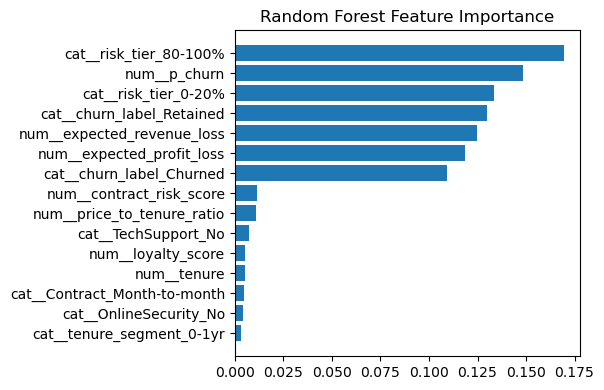

In [101]:
rf_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(n_estimators=200, random_state=42))
])

rf_pipe.fit(X_train, y_train)

importances = rf_pipe.named_steps["model"].feature_importances_

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False).head(15)

plt.figure(figsize=(6,4))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:200: UserWarning: [13:54:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


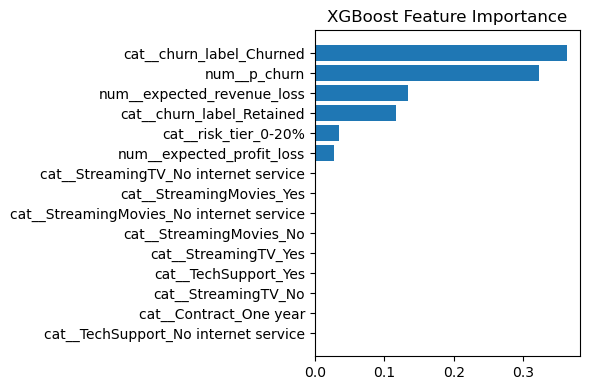

In [102]:
xgb_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        use_label_encoder=False
    ))
])

xgb_pipe.fit(X_train, y_train)

importances = xgb_pipe.named_steps["model"].feature_importances_

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False).head(15)

plt.figure(figsize=(6,4))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [107]:


# Prepare target
df_model = df.copy()
df_model["churn_flag"] = (df_model["Churn"] == "Yes").astype(int)
df_model["TotalCharges"] = pd.to_numeric(df_model["TotalCharges"], errors="coerce").fillna(0)

X = df_model.drop(columns=["customerID","Churn","churn_flag"])
y = df_model["churn_flag"]

# One-hot encode manually (SHAP-friendly)
X_encoded = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.25, random_state=42, stratify=y
)

# Train XGBoost
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss"
)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [108]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

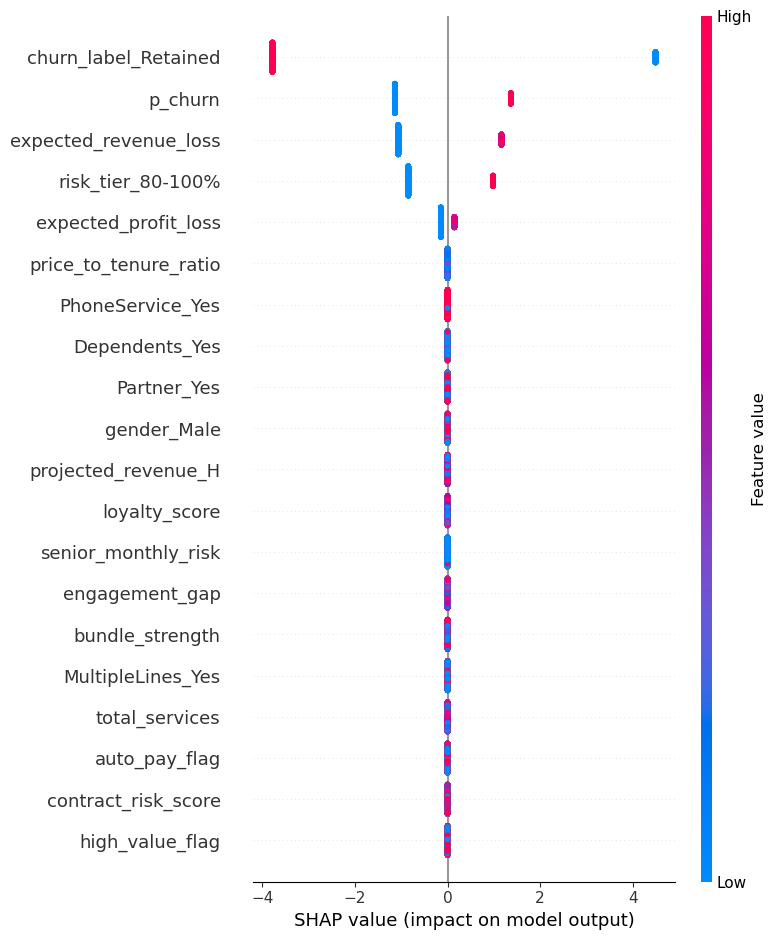

In [109]:
shap.summary_plot(shap_values, X_test)

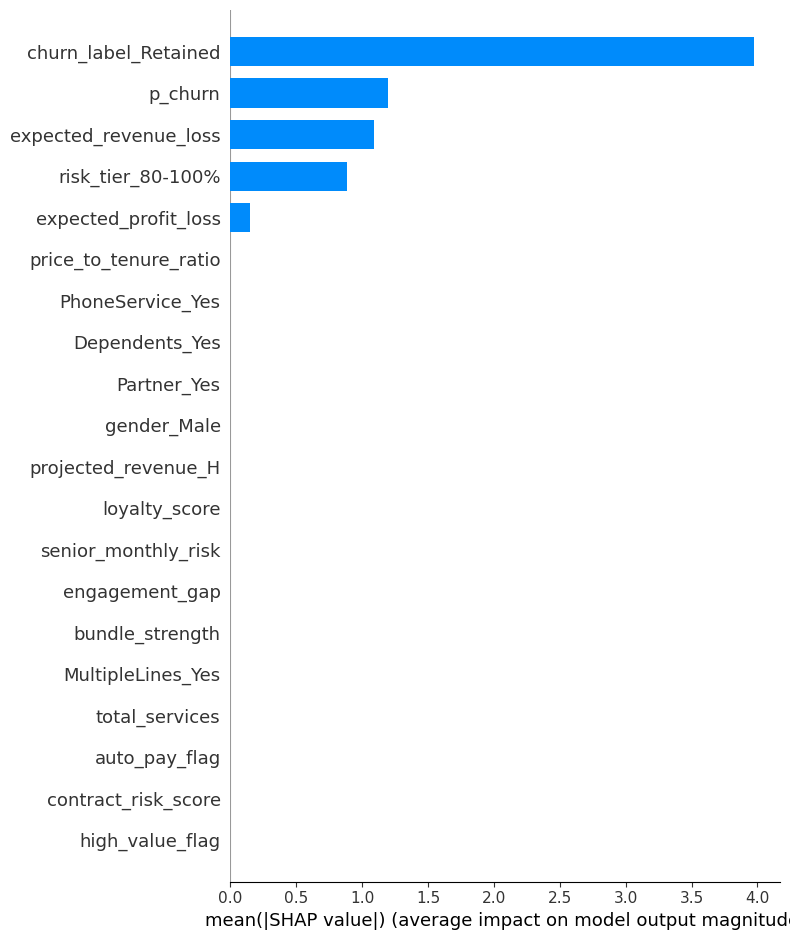

In [110]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

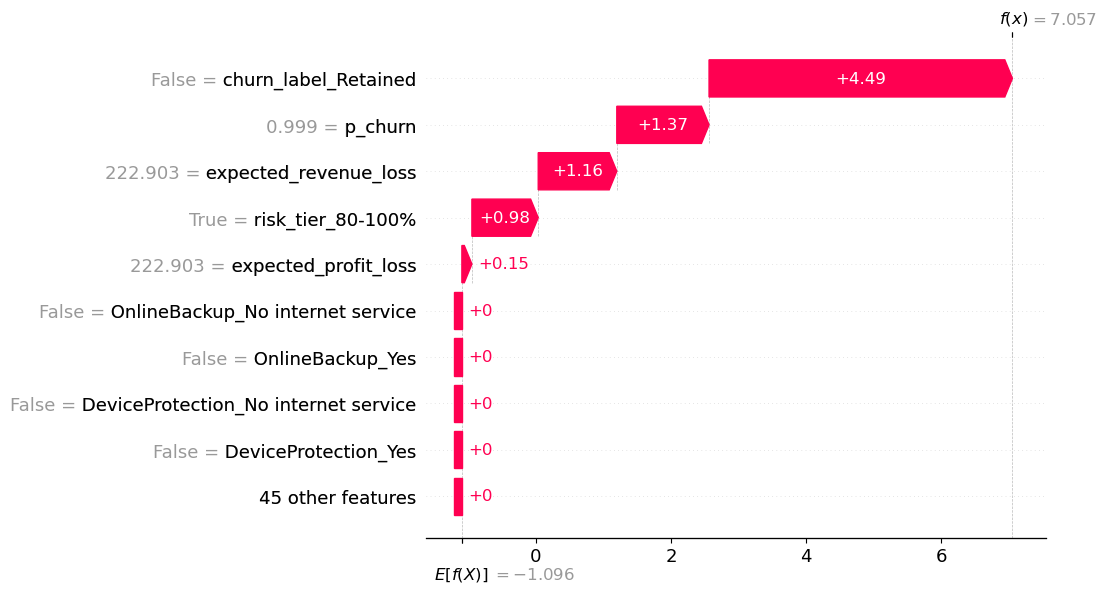

In [111]:
# Find highest predicted churn
probs = xgb.predict_proba(X_test)[:,1]
idx = np.argmax(probs)

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[idx],
        base_values=explainer.expected_value,
        data=X_test.iloc[idx],
        feature_names=X_test.columns
    )
)

In [112]:
X_test_copy = X_test.copy()
X_test_copy["p_churn"] = probs
X_test_copy["MonthlyCharges"] = df_model.loc[X_test_copy.index,"MonthlyCharges"].values
X_test_copy["expected_loss"] = X_test_copy["p_churn"] * X_test_copy["MonthlyCharges"] * 6

top_loss = X_test_copy.sort_values("expected_loss", ascending=False).head(10)
top_loss[["p_churn","MonthlyCharges","expected_loss"]]

,p_churn,MonthlyCharges,expected_loss
6038,0.999139,114.20,684.610336
1770,0.999139,113.20,678.615500
5581,0.999139,113.15,678.315758
2424,0.999139,112.95,677.116790
2204,0.999139,111.30,667.225310
6853,0.999139,111.10,666.026343
6035,0.999139,110.85,664.527634
880,0.999139,110.10,660.031506
1176,0.999139,109.90,658.832539
1644,0.999139,109.80,658.233055


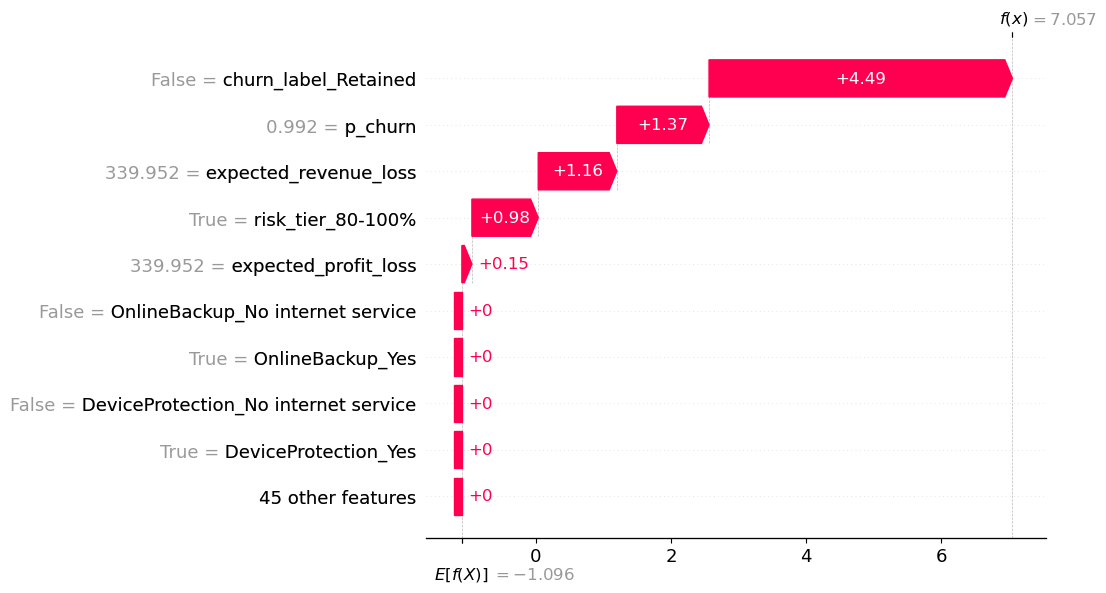

In [113]:
high_idx = top_loss.index[0]
row_position = list(X_test.index).index(high_idx)

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[row_position],
        base_values=explainer.expected_value,
        data=X_test.iloc[row_position],
        feature_names=X_test.columns
    )
)